In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

In [3]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
# Hack for those using local notebooks vs. Jupyter
# TODO, need to redo this, it doesn't really work honestly
# from pathlib import Path
# if Path("../sva").exists():
#     import sys
#     sys.path.append("..")
# else:
#     ! pip install https://github.com/matthewcarbone/ScientificValueAgent/archive/master.zip

import sys
sys.path.append("..")

In [5]:
# Import the various experiments we need for the notebook
from sva.experiments import SimpleSigmoid

# Import the helper functions for Gaussian Processes
from sva.models.gp import EasySingleTaskGP, EasyFixedNoiseGP
from sva.models.gp.plotting import plot_1d_gp

# Other utilities
from sva.utils import random_indexes, set_mpl_grids

torch default dtype set to torch.float64


/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple GP with and without noise

Let's begin with the simplest Gaussian Processes. There are two flavors of these. One with fixed noise (where noise is provided) and the second is where noise is inferred.

## Ground truth with exact mean, with and without errorbars

Consider a sigmoid function which is completely deterministic:

$$ f(x; a) = \frac{2}{1 + e^{-ax}} - 1. $$

If we know what the error bars are on each data point, we can use a `FixedNoiseGP` to force the GP to have a given uncertainty at every point. However, this is usually not the case, and it usually makes the most sense to _infer_ the noise using a `SingleTaskGP`, which will attempt to learn the uncertainty at every point. Below, we showcase what this looks like:

- A `SingleTaskGP` where noise is inferred.
- A `FixedNoiseGP` with $\sigma=0.2|x|.$
- A `FixedNoiseGP` with a poor estimate for the noise $\sigma=10^{-4}|x|.$

In [6]:
sigmoid = SimpleSigmoid(a=10.0, noise=lambda x: 0.2 * np.abs(x))

In [7]:
np.random.seed(3)
torch.manual_seed(3)

x = np.linspace(-1, 1, 500).reshape(-1, 1)
y = sigmoid(x.reshape(-1, 1))
train_indexes = random_indexes(x.shape[0], samples=10, seed=124)
x_train = x[train_indexes, :]
y_train = y[train_indexes, :]

In [8]:
y_truth = sigmoid.truth(x.reshape(-1, 1))

In [9]:
# Single task GP. Homoskedastic noise is inferred from the data.
gp1 = EasySingleTaskGP.from_default(x_train, y_train)
gp1.fit_mll()
samples1 = gp1.sample(x, samples=200)

In [10]:
# Fixed noise GP. Noise is provided a priori from the data explicitly in the
# form of error bars. Here we use the correct experimental noise to demonstrate
# the power of a fixed noise GP when the noise is known accurately.
gp2 = EasyFixedNoiseGP.from_default(x_train, y_train, Yvar=(0.2 * np.abs(x_train))**2)
gp2.fit_mll()
samples2 = gp2.sample(x, samples=200)

In [11]:
# Fixed noise GP. Here we show how badly things can go if you set the noise 
# incorrectly, since the GP is going to be force to assume that noise is correct
gp3 = EasyFixedNoiseGP.from_default(x_train, y_train, Yvar=(1e-4 * np.abs(x_train))**2)
gp3.fit_mll()
samples3 = gp3.sample(x, samples=200)

/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


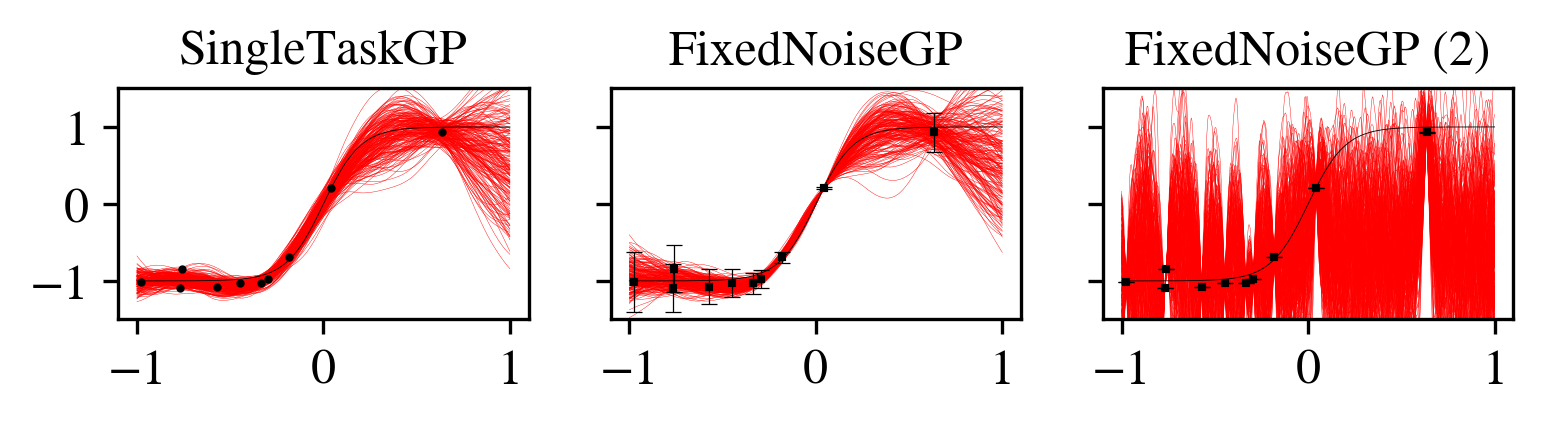

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(6, 1), sharey=True)

ax = axs[0]
ax.set_title("SingleTaskGP")
plot_1d_gp(ax, train_X=x_train, train_Y=y_train, train_Yvar=None, test_X=x, gp_samples=samples1)
ax.plot(x, y_truth, color="black", linewidth=0.2)

ax = axs[1]
ax.set_title("FixedNoiseGP")
plot_1d_gp(ax, train_X=x_train, train_Y=y_train, train_Yvar=(0.2 * np.abs(x_train))**2, test_X=x, gp_samples=samples2)
ax.plot(x, y_truth, color="black", linewidth=0.2)

ax = axs[2]
ax.set_title("FixedNoiseGP (2)")
plot_1d_gp(ax, train_X=x_train, train_Y=y_train, train_Yvar=(1e-4 * np.abs(x_train))**2, test_X=x, gp_samples=samples3)
ax.plot(x, y_truth, color="black", linewidth=0.2)

ax.set_ylim(-1.5, 1.5)

plt.show()